# 1. 데이터 사용 준비


## 1-1 사용할 패키지 준비

In [222]:
pip install pandasql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [223]:
pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 한글 폰트 다운 ( 다운 완료시 런타임 재시작 수행해주세요 )

In [224]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [225]:
import matplotlib.pyplot as plt
import pandas as pd
from pandasql import sqldf
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import KMeans
from matplotlib import rc
import numpy as np
from yellowbrick.cluster import SilhouetteVisualizer
import math
import zipfile
import warnings
warnings.filterwarnings('ignore')
rc('font', family='NanumBarunGothic')

## 1-2. 데이터 다운로드 & 불러오기

In [226]:
!gdown --id 1Qwz-dFgLNcC9zEXY3mqHoLVr73qOgTTv
zf = zipfile.ZipFile("경진대회 예선 데이터.zip")
zf.setpassword(b"nh1212!")
zf.extractall()

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Qwz-dFgLNcC9zEXY3mqHoLVr73qOgTTv
To: /content/경진대회 예선 데이터.zip
100% 12.5M/12.5M [00:00<00:00, 166MB/s]


In [227]:
cus_info = pd.read_table('./cus_ifo.csv',sep=',', dtype={x : 'str'  for x in ['mts_mm_access_type']})
kr_data = pd.read_csv('./kr_stk_orr.csv')
os_data = pd.read_csv('./oss_stk_orr.csv')
cus_tot = pd.read_table('./cus_tot_aet_ifo.csv',sep=',', dtype={x : 'str'  for x in ['mts_mm_access_type']})
cus_itg_data = pd.read_csv('./cus_itg_sct_bnc.csv')

## 1-3. 데이터 EDA

In [228]:
cus_info.columns = (['고객번호', '계좌번호', '고객정보기준년월', 'MTS월단위접속패턴', '성별', '연령대',
                      '고객자산구간코드', '수익금액구간코드', '최초계좌개설일', '주식상품보유여부', '해외주식상품보유여부',
                      '주거래상품군', 'LIFESTAGE세그먼트코드', '고객등급코드', '총투자기간세그먼트코드', '보유상품유형세그먼트코드',
                      '충성도세그먼트코드', '주거래시장구분코드', '주거래업종구분코드', '자산기준주식거래유형코드', '기본주식거래유형코드'])

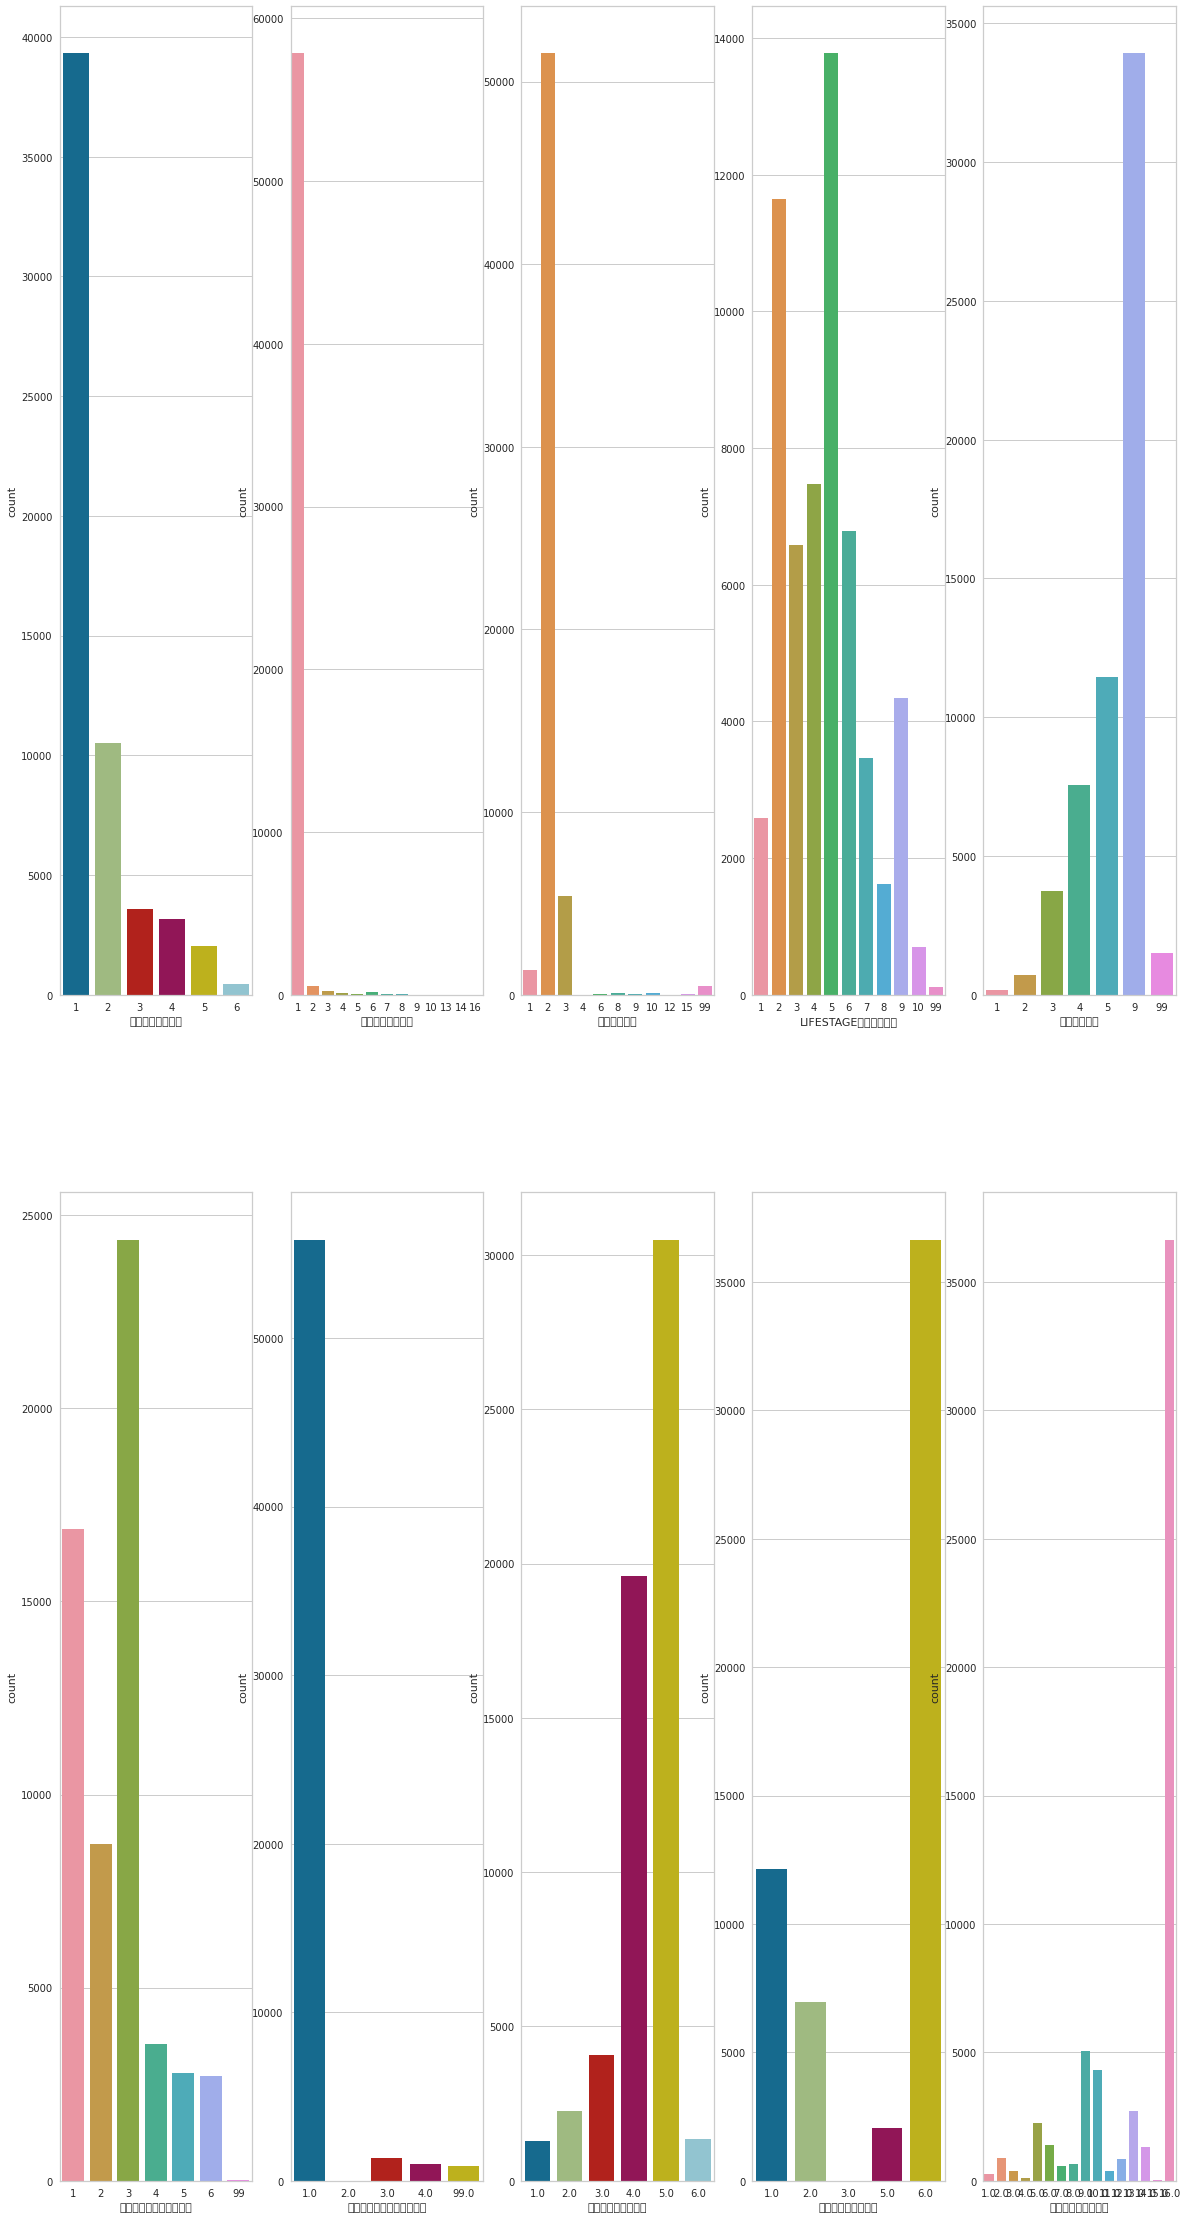

In [229]:
plt.figure(figsize=(20,40))

plt.subplot(2,5,1)
sns.countplot(cus_info['고객자산구간코드'])

plt.subplot(2,5,2)
sns.countplot(cus_info['수익금액구간코드'])

plt.subplot(2,5,3)
sns.countplot(cus_info['주거래상품군'])

plt.subplot(2,5,4)
sns.countplot(cus_info['LIFESTAGE세그먼트코드'])

plt.subplot(2,5,5)
sns.countplot(cus_info['고객등급코드'])

plt.subplot(2,5,6)
sns.countplot(cus_info['총투자기간세그먼트코드'])

plt.subplot(2,5,7)
sns.countplot(cus_info['보유상품유형세그먼트코드'])

plt.subplot(2,5,8)
sns.countplot(cus_info['충성도세그먼트코드'])

plt.subplot(2,5,9)
sns.countplot(cus_info['주거래시장구분코드'])

plt.subplot(2,5,10)
sns.countplot(cus_info['주거래업종구분코드'])





plt.show()

- 고객자산구간 : 1천만원 미만 고객(1)이 가장 많고 1천만원~ 3천만원 미만 고객(2)이 그 다음을 많다.
- 수익금액 : 고객 계좌에 100000 미만인 고객이 대부분으로 보인다.
- 주거래상품군 : 국내/해외주식이 대부분 고객의 주거래 상품이다.
- LIFESTAGE세그먼트코드 : 사회초년생과 가족성숙기-직장인 그룹이 가장 높게 분포한다.
- 고객등급 대부분이 미등급으로 분류되고 그 다음으로 블루 등급이 높다.
- 총투자기간은 1년~3년이 가장 많았으며 그 다음으로 6개월 미만의 고객이 많았다.
- 보유상품유형을 보면 주거래 상품군에 주식이 가장 많은 비중을 차지한 것과 비슷한 맥락으로 대부분이 주식인 것을 볼 수 있다.
- 충성도세그먼트는 하(4)가 가장 많고 다음으로 최하(5)가 높다.
- 주거래시장은 우선 비매매가 가장 많고 그 다음으로 거래소, 코스닥 순서로 높게 분포한다.
- 주거래업종구분 또한 비매매가 가장 많으며 그 다음으로 전기/전자와 제조업이 높게 나타났다.

---

> 수익금액, 주거래상품군, 보유상품유형 등의 컬럼을 확인한 결과, 데이터가 많이 치우쳐져 있음을 확인했다. 이는 팬데믹 이후 신규 투자자들의 유입이 급증하였고, 이러한 현상으로 자산이나 수익금액이 낮은 그룹에 치우친 것이 영향을 미친 것으로 보여진다. 또한 자산구간, 수익금액에 이어서 고객등급과 충성도세그먼트까지 치우진 모습을 보인다. 

# 2. 고객 국내주식, 해외주식 거래내역 데이터 가공하기


## 2-1 컬럼명 변경하기

### kr_data 국내주식 거래내역 데이터 컬럼명 변경

In [230]:
kr_data.columns = (['계좌번호', '주문날짜', '주문순서', '주문접수시간대', '최종체결시간대', '종목코드', '매매구분코드', '체결건수', '체결외화단가', '주문매체구분코드'])

### os_data 해외주식 거래내역 데이터 컬럼명 변경

In [231]:
os_data.columns = (['계좌번호', '주문날짜', '주문순서', '주문접수시간대', '최종체결시간대', '종목코드', '매매구분코드', '체결건수', '체결외화단가', '주문매체구분코드',
                    '거래통화코드', '거래통화환율'])

In [232]:
# kr_stk_orr 데이터와 행으로 concat하기 위해 같은 열만 가지도록 '거래통화코드', '거래통화환율' drop

os_data.drop(['거래통화코드', '거래통화환율'], axis=1, inplace=True)

거래통화코드와 거래통화환율 컬럼은 분석 방향에 영향을 주지 않다고 판단하여 제거

## 2-2 국내/해외주식 거래내역 데이터 concat 후 그룹화
  - 국내주식/ 해외주식 데이터 concat => total_stk
  - 그룹화 한 데이터프레임 => stk_week_group

In [233]:
total_stk = pd.concat([kr_data, os_data], axis=0)

### 한 계좌당 주 단위 거래 횟수 => stk_week
- 주 단위 정의 (일요일~월요일)
- 주말을 제외하고 다음과 같은 방식으로 표기
  - 1/3 -> 1/3
  - 1/4 ~ 1/10 -> 1/10
  - 6/27 ~ 6/30 -> 7/4

In [ ]:
# 주문날짜 -> datetime 형태로 변경
total_stk['주문날짜'] = total_stk['주문날짜'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
total_stk.set_index(total_stk['주문날짜'], inplace=True)

# 거래횟수 count하기 위해 'CNT' 컬럼 생성
total_stk['CNT'] = 1

# 한 계좌번호 당 주단위로 거래 횟수 :  CNT count 값 
# 거래내역과 거래내역 사이 거래가 없는 주는 NaN 값으로 0 처리
stk_week = pd.DataFrame(total_stk.groupby(['계좌번호']).resample('W-Mon')['CNT'].agg(np.sum).fillna(0))

#하나의 계좌 당 행 수를 count
stk_week_count = pd.DataFrame(stk_week.groupby('계좌번호').count()['CNT'])


- CNT :  2022년 1월 ~ 6월 기간 중 한 계좌가 처음으로 주문을 한 날짜가 속한 주에서 마지막으로 주문한 날짜가 속한 주까지의 총 찍힌 주의 수 
- 계좌별 그룹화 한 뒤 행 수 count

### 한 계좌 당 찍힌 주의 수에 따라 그룹화  => stk_week_count
- 행의 수(총 주의 수)가 20~27개 :  group 0 
- 행의 수(총 주의 수)가 9~19개 :  gorup 1 
- 행의 수(총 주의 수)가 1개~8개 :  group 2

In [ ]:
stk_week_count['group'] = 0
for i in range(len(stk_week_count)): 
  if stk_week_count['CNT'][i] >= 20 :
    stk_week_count['group'][i] = 0
  elif stk_week_count['CNT'][i] >= 9 :
    stk_week_count['group'][i] = 1
  else:
    stk_week_count['group'][i] = 2

# 3. cus_ifo 데이터 가공하기 => cus_info
- 고객 정보 data

## 3-1. 컬럼명 변경

In [ ]:
cus_info.columns = (['고객번호', '계좌번호', '고객정보기준년월', 'MTS월단위접속패턴', '성별', '연령대',
                      '고객자산구간코드', '수익금액구간코드', '최초계좌개설일', '주식상품보유여부', '해외주식상품보유여부',
                      '주거래상품군', 'LIFESTAGE세그먼트코드', '고객등급코드', '총투자기간세그먼트코드', '보유상품유형세그먼트코드',
                      '충성도세그먼트코드', '주거래시장구분코드', '주거래업종구분코드', '자산기준주식거래유형코드', '기본주식거래유형코드'])

## 3-2. 기준년월 6월인 최근 고객 데이터만 추출 -> cus_uni
- 중복 데이터에서 가장 최근인 6월의 데이터만 추출

In [ ]:
# 고객번호 중복없이 추출
cus_num = cus_info['고객번호'].unique()

In [ ]:
# 기준년월이 6월인 고객 데이터만 추출하는 함수
def get_cus_6(df_, cus_nums) :
    sum_df = pd.DataFrame()

    for i in cus_nums :
        sep = df_.loc[df_['고객번호'].isin([i])]
       
        new_sep = sep.loc[sep['고객정보기준년월']==sep['고객정보기준년월'].max()].copy()

        sum_df = pd.concat([sum_df, new_sep], axis=0)
        sum_df.reset_index(inplace=True, drop=True)
    return sum_df

In [ ]:
#중복된 고객 없이 6월 기준 고객 데이터 저장 => cus_uni
cus_uni = get_cus_6(cus_info,cus_num)

# 4. cus_tot_aet_ifo 데이터 가공하기 => cus_tot
- 고객 자산 정보 data

In [ ]:
cus_tot.columns = ['고객번호','계좌번호','MTS월단위접속패턴','2022년1월총자산','2022년2월총자산','2022년3월총자산','2022년4월총자산','2022년5월총자산','2022년6월총자산']

## 4-1. 월별 변동률 계산하기 

### 4-1.1 월 자산 NaN ->  다음 월 자산으로 채워넣기


In [ ]:
cus_tot = cus_tot.fillna(method='bfill', axis=1)

# 계산을 위해 float형태로 변환
cus_tot = cus_tot.astype({'2022년1월총자산':'float64', '2022년2월총자산':'float64', '2022년3월총자산':'float64', '2022년4월총자산':'float64', '2022년5월총자산':'float64', '2022년6월총자산':'float64'})

### 4-1.2  월별 평균변동률 파생변수 생성

In [ ]:
cus_tot["1,2월 변동률"] = (cus_tot["2022년2월총자산"] - cus_tot["2022년1월총자산"]) / cus_tot['2022년1월총자산'] *100
cus_tot["2,3월 변동률"] = (cus_tot["2022년3월총자산"] - cus_tot["2022년2월총자산"]) / cus_tot['2022년2월총자산'] *100
cus_tot["3,4월 변동률"] = (cus_tot["2022년4월총자산"] - cus_tot["2022년3월총자산"]) / cus_tot['2022년3월총자산'] *100
cus_tot["4,5월 변동률"] = (cus_tot["2022년5월총자산"] - cus_tot["2022년4월총자산"]) / cus_tot['2022년4월총자산'] *100
cus_tot["5,6월 변동률"] = (cus_tot["2022년6월총자산"] - cus_tot["2022년5월총자산"]) / cus_tot['2022년5월총자산'] *100

# 월 총 자산이 연속으로 0 값을 가지게 되면 그 월들의 변동률은 NaN  => 변동률 없는 것으로 판단하여 0으로 대체
cus_tot = cus_tot.fillna(0)


## 4-2. 총변동률 계산
   - 월별 변동률의 폭을 보기 위해 가장 큰 변동률 값(max), 가장 작은 변동률 값(min) 절댓값을 이용해 총변동률 계산

In [ ]:
cus_tot["max"] = cus_tot.loc[:, ['1,2월 변동률', '2,3월 변동률','3,4월 변동률','4,5월 변동률','5,6월 변동률']].max(axis=1) 
cus_tot["min"] = cus_tot.loc[:, ['1,2월 변동률', '2,3월 변동률','3,4월 변동률','4,5월 변동률','5,6월 변동률']].min(axis=1) 

# max와 min 절댓값 이용
cus_tot['max_abs']= cus_tot['max'].abs()
cus_tot['min_abs']= cus_tot['min'].abs()

# 월 총 자산이 0으로 나타나고 다음 월 총 자산이 0이 아닌 정수를 가지게 되면 변동률 Inf 값 가짐 => 결국엔 변동률 없는 것이므로 0으로 대체
cus_tot = cus_tot.replace([np.inf, -np.inf], 0)

cus_tot["총변동률"] = cus_tot['min_abs'] + cus_tot['max_abs']

## 4-3. 사용할 컬럼 추출 => cus_total

In [ ]:
cus_total = cus_tot[['고객번호', '계좌번호', '총변동률']]

# 5. 데이터를 결합해 새로운 데이터프레임 생성

## 5-1. cus_uni와 cus_total 데이터프레임 merge => cust_info
- 고객 정보에 변동률 컬럼 추가

In [ ]:
cust_info = pd.merge(cus_uni, cus_total, on='계좌번호', how='outer')

# 고객 번호 컬럼이 두개 생기게 됨 -> 한 컬럼 삭제하고 컬럼명 변경

cust_info.drop(['고객번호_y'], axis=1, inplace=True)
cust_info.rename(columns = {'고객번호_x':'고객번호'}, inplace=True)

## 5-2 stk_week_count과 cust_info merge => cust_info
- 고객 정보에 한 계좌당 CNT(총 주의 수), group(CNT에 따라 그룹 분류)컬럼 추가 

In [ ]:
cust_info = pd.merge(cust_info, stk_week_count , how='outer',on='계좌번호')

In [ ]:
# 사용하지 않을 컬럼 삭제

cust_info.drop(['고객정보기준년월', '성별', '고객자산구간코드', '수익금액구간코드', '주식상품보유여부', '해외주식상품보유여부', '고객등급코드',
                '충성도세그먼트코드', 'CNT'], axis=1, inplace=True)

- 고객정보기준년월 : 위에서 가장 최근 데이터를 추출하였기 때문에 삭제
- 성별, 연령대 대신에 고객 성향이 더 잘 드러나는 lifestage세그먼트코드로 대신 사용하였다.
- 고객자산구간코드, 수익금액구간코드, 고객등급코드, 충성도세그먼트코드 : 1-3에서 데이터 EDA로 확인한 결과, 사용하지 않는 것으로 판단
- 주식/해외주식 상품 보유 여부는 앞에서 국내/해외주식 거래내역 데이터를 사용하여 제외하도록 한다.


In [ ]:
# 최초계좌개설일 datetime 형태로 변경

cust_info['최초계좌개설일'] = cust_info['최초계좌개설일'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))

# 6. 그룹화

## 6-1. group_A : 2022년에 주식 거래를 하지 않은 사람 (3033명)
- group이 NaN 값인 고객들
- 즉, 2022년 1월~6월에 주문이 존재하지 않는 사람들

In [ ]:
group_A = cust_info[cust_info['group'].isnull()]

### group 컬럼이 2인 고객 (1~8주) => group_BC (2604명)
- 첫 거래일을 포함한 주 ~ 마지막 거래일을 포함한 주 까지 주 수로 count 했을 때 1~8 사이의 값을 가진 고객들이다
- 거래 기간이 짧은 고객으로 볼 수 있으나 그 안에서
  - 1.신규고객으로 거래 기간이 짧은 고객
  - 2.거래 기간은 짧지만 꾸준히 한 고객
  - 3.거래 기간도 짧고 거래 사이 term이 긴 고객
  으로 나눌 수 있다.
- 거래 기간이 짧지만 꾸준히 한 고객이어도 전체 주(27주)수에 비해 비교적 많이 짧은 기간이라고 판단하여 <br>
1번 : 신규고객(groupB) <br>
2,3번 : 거래를 거의 하지 않은 고객(groupC) 그룹으로 분류하였다.

In [ ]:
group_BC = cust_info[cust_info['group']==2]

## 6-2. group_B  : 최초계좌개설일이 최근인 고객(신규고객) (67명)
- 신규고객은 5월,6월에 계좌를 개설한 고객 대상으로 판단하였다.

In [ ]:
group_BC = group_BC.set_index('최초계좌개설일')

In [ ]:
# 2022년 5월에서 6월 사이에 계좌를 최초로 개설한 고객을 분류

group_B = group_BC['2022-05-01':'2022-06-30']
group_B.reset_index(inplace=True)

## 6-3. group_C : group 컬럼 == 2 인 고객 중 신규고객 제외한 나머지 고객(2537명)

In [ ]:
group_BC.reset_index(inplace=True)

# group_BC에서 group_B 제외한 것 -> group_C
group_C = pd.concat([group_BC, group_B]).drop_duplicates(keep=False)

### group 컬럼이 0과 1인 고객 => group_DEF (4363명)
- 주 수를 count한 그룹 중 0,1 그룹은 2 그룹보다 비교적 긴 거래기간(첫 거래일을 포함한 주~ 마지막 거래일을 포함한 주)을 가진다. 
- group 컬럼에 대한 내용은 목차 2-2 내용 참고
- 그 중에서도 거래와 거래 사이 term이 긴 고객들을 다른 그룹으로 분류한다.

In [ ]:
group_DEF = cust_info[(cust_info['group']==0) | (cust_info['group']==1)]

In [ ]:
account_DEF = group_DEF['계좌번호'].unique()

### stk_week 에서 group_ABD인 고객만 추출 => stk_week_DEF

In [ ]:
stk_week.reset_index(inplace=True)

In [ ]:
stk_week_DEF = pd.DataFrame()
for i in tqdm(account_DEF) :
  stk_week_DEF = pd.concat([stk_week_DEF, stk_week[stk_week['계좌번호'] == i]])

In [ ]:
stk_week_count_DEF = pd.DataFrame(stk_week_DEF.groupby('계좌번호').count()['CNT']).reset_index()

stk_DEF = pd.merge(stk_week_DEF, stk_week_count_DEF, on='계좌번호')
stk_DEF.rename(columns={'CNT_x':'주단위주문량', 'CNT_y':'총주의수'}, inplace=True)
stk_DEF_account = stk_week_count_DEF['계좌번호'].unique()

### 주단위 당 주문량의 수가 0인 것의 개수 70% 기준으로 구분
- 거래 기간 주 수 중에서 실제 거래하지 않은 주 수(0의 개수)가 70% 이상인 그룹을 분류한다.
- 이 그룹은 거래 기간은 길지만 거래와 거래 사이의 term(=거래를 하지 않은 주)이 길기 때문에 다른 그룹으로 분류하였다. 

In [ ]:
DEF = pd.DataFrame(stk_DEF.groupby(['계좌번호'])['주단위주문량'].value_counts())
DEF.rename(columns={'주단위주문량':'총주의수'}, inplace=True)
DEF.reset_index(inplace=True)

In [ ]:
DEF_2 = pd.DataFrame(DEF.groupby('계좌번호')['총주의수'].sum())
DEF_2.reset_index(inplace=True)

In [ ]:
DEF_3 = pd.merge(DEF, DEF_2, on='계좌번호')
DEF_3.rename(columns={'총주의수_x':'총주의수', '총주의수_y':'week_cnt'}, inplace=True)

In [ ]:
# 주단위주문량 컬럼의 값이 0인 주의 수가 week_cnt(전체 주의 수)의 70% 이상이면 pct 컬럼 값 1으로  

DEF_3['pct'] = 0

for i in range(len(DEF_3)) :
  if DEF_3['주단위주문량'][i] == 0:
    if DEF_3['총주의수'][i] / DEF_3['week_cnt'][i] >= 0.7 :
      DEF_3['pct'][i] = 1
    else : DEF_3['pct'][i] = 0
  else : DEF_3['pct'][i] = 'NaN'

## 6-4. group_D : group_DEF 중 거래 term이 긴 고객
- 거래 term이 긴 고객의 의미 : 9-19주(group 1), 20-27(group 0)로<br>
  거래 횟수가 많은 그룹으로 분류가 되어도, <br>
  처음 주문한 주부터 다음 거래까지 term이 있는 경우 거래 내역이 없는 주도 출력되어 count된다.

- 예시: 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 

#### group_D : pct 컬럼 값이 1인 고객들 추출 (거래 term이 긴 고객, 1307명)

In [ ]:
pct1_cus = pd.DataFrame(DEF_3[DEF_3['pct']==1]['계좌번호'])

In [ ]:
group_D = pd.merge(pct1_cus, group_DEF, on='계좌번호', how='left')

#### group_DEF에서 group_D 제외 => group_EF
- 거래 사이 term이 긴 고객을 제외하였기 때문에, 매주 빈번하게 거래한 고객들이 남는다.
- 남은 고객들은 20-27 / 9-19  두 그룹으로 분류하였다.

In [ ]:
group_EF = pd.concat([group_DEF, group_D]).drop_duplicates(keep=False)

## 6-5. group_E : group D를 제외한 거래 주 count가 20-27인 고객(2020명)
- group 컬럼 값이 0인 고객

In [ ]:
group_E = group_EF[group_EF['group']==0]

## 6-6. group_F : group D를 제외한 거래 주 count가 9-19인 고객(1036명)
- group 컬럼 값이 1인 고객

In [ ]:
group_F = group_EF[group_EF['group']==1]

# 7. 시각화

## 7-1.그룹별 lifestage 확인 (시각화)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(30,10))

plt.subplot(1,6,1)
plt.subplot(1,6,1).title.set_text("group_A의 lifestage")
sns.countplot(data = group_A, x = 'LIFESTAGE세그먼트코드')

plt.subplot(1,6,2)
plt.subplot(1,6,2).title.set_text("group_B의 lifestage")
sns.countplot(data = group_B, x = 'LIFESTAGE세그먼트코드')

plt.subplot(1,6,3)
plt.subplot(1,6,3).title.set_text("group_C의 lifestage")
sns.countplot(data = group_C, x = 'LIFESTAGE세그먼트코드')

plt.subplot(1,6,4)
plt.subplot(1,6,4).title.set_text("group_D의 lifestage")
sns.countplot(data = group_D, x = 'LIFESTAGE세그먼트코드')

plt.subplot(1,6,5)
plt.subplot(1,6,5).title.set_text("group_E의 lifestage")
sns.countplot(data = group_E, x = 'LIFESTAGE세그먼트코드')

plt.subplot(1,6,6)
plt.subplot(1,6,6).title.set_text("group_F의 lifestage")
sns.countplot(data = group_F, x = 'LIFESTAGE세그먼트코드')

plt.show()

### 각 그룹별 lifestage 세그먼트코드 설명
#### 1:미성년 , 2:사회초년생, 3:가족형성기_남자, 4:가족형성기_여자, 5:가족성숙기_직장인 , 6:가족성숙기_주부, 7:가족성숙기_남자, 8:가족성숙기_여자, 9:은퇴기, 10:노년기, 99:미정의

In [ ]:
plt.figure(figsize=(30,10))

plt.subplot(1,6,1)
plt.subplot(1,6,1).title.set_text("group_A의 연령대")
sns.countplot(data = group_A, x = '연령대')

plt.subplot(1,6,2)
plt.subplot(1,6,2).title.set_text("group_B의 연령대")
sns.countplot(data = group_B, x = '연령대')

plt.subplot(1,6,3)
plt.subplot(1,6,3).title.set_text("group_C의 연령대")
sns.countplot(data = group_C, x = '연령대')

plt.subplot(1,6,4)
plt.subplot(1,6,4).title.set_text("group_D의 연령대")
sns.countplot(data = group_D, x = '연령대')

plt.subplot(1,6,5)
plt.subplot(1,6,5).title.set_text("group_E의 연령대")
sns.countplot(data = group_E, x = '연령대')

plt.subplot(1,6,6)
plt.subplot(1,6,6).title.set_text("group_F의 연령대")
sns.countplot(data = group_F, x = '연령대')

plt.show()

연령대 구분 
  - 01: 25세 미만 / 02: 25세 이상 30세 미만 / 03: 30 세 이상 35세 미만
  - 04: 35 세 이상 40세 미만 / 05: 40 세 이상 45세 미만
  - 06: 45 세 이상 50세 미만 / 07: 50 세 이상 55세 미만
  - 08: 55 세 이상 60세 미만 / 09:  60 세 이상 65세 미만
  - 99: 미정의 (NULL 값)


##7-2. 그룹별 주거래시장구분코드 확인 (시각화)

In [ ]:
plt.figure(figsize=(30,10))

plt.subplot(1,6,1)
plt.subplot(1,6,1).title.set_text("group_A의 주거래시장")
sns.countplot(data = group_A, x = '주거래시장구분코드')

plt.subplot(1,6,2)
plt.subplot(1,6,2).title.set_text("group_B의 주거래시장")
sns.countplot(data = group_B, x = '주거래시장구분코드')

plt.subplot(1,6,3)
plt.subplot(1,6,3).title.set_text("group_C의 주거래시장")
sns.countplot(data = group_C, x = '주거래시장구분코드')

plt.subplot(1,6,4)
plt.subplot(1,6,4).title.set_text("group_D의 주거래시장")
sns.countplot(data = group_D, x = '주거래시장구분코드')

plt.subplot(1,6,5)
plt.subplot(1,6,5).title.set_text("group_E의 주거래시장")
sns.countplot(data = group_E, x = '주거래시장구분코드')

plt.subplot(1,6,6)
plt.subplot(1,6,6).title.set_text("group_F의 주거래시장")
sns.countplot(data = group_F, x = '주거래시장구분코드')

plt.show()

### 각 그룹별 주거래시장 설명
#### 1.0:거래소, 2.0:코스닥, 3.0:ELW, 4.0:외화주식, 5.0:혼합, 6.0:비매매

## 7-3. 그룹별 주거래업종구분코드 확인 (시각화)

In [ ]:
plt.figure(figsize=(30,10))

plt.subplot(1,6,1)
plt.subplot(1,6,1).title.set_text("group_A의 주거래업종구분")
sns.countplot(data = group_A, x = '주거래업종구분코드')

plt.subplot(1,6,2)
plt.subplot(1,6,2).title.set_text("group_B의 주거래업종구분")
sns.countplot(data = group_B, x = '주거래업종구분코드')

plt.subplot(1,6,3)
plt.subplot(1,6,3).title.set_text("group_C의 주거래업종구분")
sns.countplot(data = group_C, x = '주거래업종구분코드')

plt.subplot(1,6,4)
plt.subplot(1,6,4).title.set_text("group_D의 주거래업종구분")
sns.countplot(data = group_D, x = '주거래업종구분코드')

plt.subplot(1,6,5)
plt.subplot(1,6,5).title.set_text("group_E의 주거래업종구분")
sns.countplot(data = group_E, x = '주거래업종구분코드')

plt.subplot(1,6,6)
plt.subplot(1,6,6).title.set_text("group_F의 주거래업종구분")
sns.countplot(data = group_F, x = '주거래업종구분코드')

plt.show()

### 그룹별 주거래업종 그래프 설명
#### 1.0:건설업, 2.0:금융업, 3.0:기계, 4.0:방송/통신, 5.0:서비스/오락/문화, 6.0:운송/운수, 7.0:유통, 8.0:의료/의약, 9.0:전기/전자, 10.0:제조, 11.0:철강, 12.0:화학, 13.0:IT, 14.0:기타, 15.0:혼합, 16.0:비매매

- Group_A(3033명) : 2022년 1월부터 6월까지 주식 거래를 하지 않은 고객 이 
  - LIFESTAGE세그먼트를 보면 가족성숙기_직장인, 사회초년생, 가족형성기_여자 순으로 높다.
  - 2022년도부터 1월에서 6월까지의 거래 데이터가 없는 그룹이기에 주거래 시장과 주거래 업종에서 비매매가 압도적으로 높다.
  - 하지만 주거래 시장에서 '거래소와 코스닥이 조금은 존재한다'라는 부분과 주거래업종에서도 제조와 전기/전자가 존재한다는 것을 1월~6월 사이 거래는 없었지만 이전에 관심있는 주식을 보유했던 것으로 보인다.

- Group_B(67명)는 최초계좌개설일이 최근인 고객이다. 주식 거래기간이 짧은 고객들 중 최근에 계좌를 만든 고객들(전체 데이터 1~6월 중 5월, 6월에 계좌를 개설한 고객)을 따로 분류하였다. 
  - LIFESTAGE세그먼트를 확인하면 미성년(연령대로 살펴보면 25세 이하 그룹이 가장 높다.) 가족성숙기-직장인, 사회초년생 그룹 순서로 높게 나타났다. 
  - 주거래업종은 제조, 전기/전자에 주로 분포하였고 거래소, 코스닥 시장을 주로 이용한다. 그룹 내에서 변동률이 높은 그룹(1)에는 동일하게 미성년 그룹이 가장 높고 0 그룹에서는 가족성숙기-직장인 그룹이 가장 높았다. 
  
- Group_C(2537명)은 신규고객을 제외하고 주거래가 1주-8주동안 주식거래를 한 고객이다. 
  - LIFESTAGE세그먼트를 보면 가족성숙기_직장인,사회초년생,가족형성기_여자 순으로 높다.
  - 주거래시장은 비매매가 압도적으로 높았으며 거래소, 코스닥 순으로 높게 나타났다.

- Group_D는 거래 term이 길다고 판단되는 고객 그룹이다.
  - LIFESTAGE는 가족성숙기_직장인, 사회초년생, 가족형성기_여자 순으로 많은 것으로 나타났다. 
  - 주거래업종코드는 비매매를 제외하고 전기/전자, 제조 업종에서 높다.
  
- group_E는 20주에서 27주 동안 꾸준히 거래를 한 고객 그룹이다.
  - 이 그룹의 LIFESTAGE는 가족성숙기_직장인, 가족성숙기_주부, 가족형성기_남자 순으로 많은 것으로 나타났다. 다른 그룹과는 다르게 사회초년생의 비중이 높지 않다.
  - 주거래업종코드는 전기/전자, 제조 업종에서 높게 나왔으며 비매매의 비중 또한 전체 데이터 분포와는 다르게 높지 않았다.
  
- group_F는 9~19주 동안 꾸준히 거래를 한 고객이다. 
  - LIFESTAGE는 가족성숙기-직장인, 사회초년생, 가족 형성기_남자 그룹 순서로 높게 나타났다. 
  - 비매매의 비중이 가장 높고 그 다음으로 거래소로 나타났으며 전기/전자, 제조 산업에 주로 투자하는 것으로 보인다. 변동률이 높은 그룹(1)에서는 사회초년생과 가족성숙기-직장인이 그룹(0)에서도 동일하게 나타났다.

#8. 변동률_group 생성
- 그룹별 변동률 확인
- 정규화 후 3사분위수를 기준으로 높으면 1, 낮으면 0으로

In [ ]:
# 정규화하고 3사분위수를 기준으로 높으면 1, 낮으면 0으로 '변동률_group' 컬럼 만드는 함수

from sklearn.preprocessing import MaxAbsScaler

def func1(x):
  scaler = MaxAbsScaler()
  x['총변동률'] = scaler.fit_transform(np.array(x['총변동률']).reshape(-1,1))

  Q3 = np.quantile(x['총변동률'], .75)
  x.reset_index(inplace=True, drop=True)
  x['변동률_group'] = 0
  for i in range(len(x)) :
    if x['총변동률'][i] >= Q3 :
      x['변동률_group'][i] = 1
    else : x['변동률_group'][i] = 0
  return Q3

In [ ]:
func1(group_A)
func1(group_B)
func1(group_C)
func1(group_D)
func1(group_E)
func1(group_F)

## 8-1 변동률(group)별 시각화

In [ ]:
plt.figure(figsize=(30,10))

plt.subplot(1,6,1)
sns.countplot(data = group_A, x = '변동률_group', hue='기본주식거래유형코드').set_title("group_A의 기본주식거래유형-변동률")

plt.subplot(1,6,2)
sns.countplot(data = group_B, x = '변동률_group', hue='기본주식거래유형코드').set_title("group_B의 기본주식거래유형-변동률")

plt.subplot(1,6,3)
sns.countplot(data = group_C, x = '변동률_group', hue='기본주식거래유형코드').set_title("group_C의 기본주식거래유형-변동률")

plt.subplot(1,6,4)
sns.countplot(data = group_D, x = '변동률_group', hue='기본주식거래유형코드').set_title("group_D의 기본주식거래유형-변동률")

plt.subplot(1,6,5)
sns.countplot(data = group_E, x = '변동률_group', hue='기본주식거래유형코드').set_title("group_E의 기본주식거래유형-변동률")

plt.subplot(1,6,6)
sns.countplot(data = group_F, x = '변동률_group', hue='기본주식거래유형코드').set_title("group_F의 기본주식거래유형-변동률")

plt.show()

기본주식거래유형코드
- 001 : Scalper, 002:Day Trader, 003:Swing Trader, 
- 004: General Trader, 005: Occasional Trader, 006: Long-Term Trader,
- 007:입고/공모/배당, 008: Recent Dormancy, 009: Dormancy, 010: Stock Holder, 011: Break Out


- 변동률 group은 월별 평균변동률 중 가장 높은 변동률(max)과 가장 낮은 변동률(min)의 절댓값 합으로 차를 확인하고 그 중 변동률이 높은 상위 25%를 그룹1, 나머지 고객을 그룹0으로 나누어 그룹별 기본주식거래유형코드를 확인한 결과이다.

groupA:
groupA
groupA
groupA
groupA
groupA

# 9. cus_itg_sct_bnc.csv 데이터 가공하기 => cus_itg_data

In [ ]:
cus_itg_data.columns = ['계좌번호','기준년월','종목코드','외화증권거래국가코드','통합상품유형코드','결제기준통합잔고수량','통합매수체결수량','통합매도체결수량','체결기준통합잔고수량',
                        '결제기준현재평가금액','결제기준외화현재평가금액','체결기준현재평가금액','체결기준외화현재평가금액','체결기준대출금액','거래통화코드']

In [ ]:
cus_itg = pd.DataFrame(cus_itg_data.pivot_table(["체결기준통합잔고수량"], index=["계좌번호", "종목코드","기준년월"]))

cus_itg = cus_itg.sort_values('기준년월', ascending=False)

cus_itg.reset_index(inplace=True)

## 9-1. 계좌별 한 종목코드 당 체결기준통합잔고수량 출력 => recent_stock
- 가장 최근의 체결기준통합잔고수량을 기준으로 출력

In [ ]:
recent_stock = cus_itg.drop_duplicates(['계좌번호', '종목코드'], keep='first')

In [ ]:
recent_stock.reset_index(inplace=True, drop=True)

## 9-2. 계좌별 체결기준통합잔고수량이 큰 종목코드 선택 => stock_Large
- 계좌별 체결기준통합잔고수량이 가장 큰 종목 하나씩만 선택
- 계좌별 가장 많이 보유한 종목 파악

In [ ]:
stock_L = pd.DataFrame(recent_stock.pivot_table(["체결기준통합잔고수량","기준년월"], index=["계좌번호", "종목코드"]))
stock_L = stock_L.sort_values(['계좌번호', '체결기준통합잔고수량'], ascending=False)
stock_L.reset_index(inplace=True)

In [ ]:
stock_Large = stock_L.drop_duplicates(['계좌번호'], keep='first')

## 9-3. 그룹별 LIFESTAGE 분포에서 상위 3개 그룹의 종목코드 확인
- group_A, B 고객은 거래를 하지 않았거나, 신규 고객이기 때문에 분석에서 제외
- group_C, group_D, group_E, group_F 그룹만 종목 확인


### 9-3.1 그룹별 lifestage 상위 3개에 속한 고객들을 기준으로 같은 종목이 많은 순으로 출력

In [ ]:
def filter_top3(x):
  qq = x.groupby('LIFESTAGE세그먼트코드').count().sort_values(by ='고객번호', ascending = False)
  top3 = qq.index[:3]
  print(top3)

  filter_group = x[(x['LIFESTAGE세그먼트코드'] == top3[0]) | (x['LIFESTAGE세그먼트코드'] == top3[1]) | (x['LIFESTAGE세그먼트코드'] == top3[2])]

  group_stock = pd.merge(filter_group, stock_Large, on='계좌번호', how='inner')
  result = group_stock.groupby(['종목코드']).count().sort_values('고객번호', ascending=False)

  
  return result

In [ ]:
filter_top3(group_B)

### 9-3.2 group_C => group_C_stock

In [ ]:
group_C_stock = filter_top3(group_C)

### 9-3.3 group_D => group_D_stock

In [ ]:
group_D_stock = filter_top3(group_D)

### 9-3.4 group_E => group_E_stock

In [ ]:
group_E_stock = filter_top3(group_E)

### 9-3.5 group_F => group_F_stock

In [ ]:
group_F_stock = filter_top3(group_F)

## 9-4 상위 10개 종목 파이차트 시각화

In [ ]:
def pie_chart(x) : 
  slang_usage = x.index[:10]
  values = x['고객번호'][:10]
  plt.pie(values, labels = slang_usage, autopct='%.1f%%',startangle=90, counterclock=False)

**group_C 상위 종목**

In [ ]:
pie_chart(group_C_stock)

**group_D 상위 종목**

In [ ]:

pie_chart(group_D_stock)

**group_E 상위 종목**

In [ ]:
pie_chart(group_E_stock)

**group_F 상위 종목**

In [ ]:
pie_chart(group_F_stock)

In [ ]:
group_A.to_csv('./group_A.csv', encoding="utf-8")
group_B.to_csv('./group_B.csv', encoding="utf-8")
group_C.to_csv('./group_C.csv', encoding="utf-8")
group_D.to_csv('./group_D.csv', encoding="utf-8")
group_E.to_csv('./group_E.csv', encoding="utf-8")
group_F.to_csv('./group_F.csv', encoding="utf-8")

